In [8]:
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

from orthnet import Legendre, Chebyshev

%matplotlib inline

In [9]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [10]:
class LegendreActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 , i):
            if (i + j) % 2 == 1:
              self.D[i, j] = 2 * (j + 1) - 1
    
    def forward(self, X):              
      data = Legendre(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T


class LegendreBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Legendre = LegendreActivation(self.degree)

    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Legendre(X)
      return data

class ChebyshevActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 ,i):
            if (i+j) % 2 == 1:
              self.D[i, j] = 2 * i
              if j == 0:
                self.D[i, j] = self.D[i, j]/2.0
    def forward(self, X):              
      data = Chebyshev(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T

class ChebyshevBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Chebyshev = ChebyshevActivation(self.degree)


    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Chebyshev(X)
      
      return data

In [11]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)

In [12]:
domain = [0, 1]
n_discretization = 500 * domain[1] - domain[0]

In [13]:
n_input = 1
n_output = 1
eps = 1e-10

In [14]:
x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double).reshape(-1,1)
x = Variable(x, requires_grad=True).double()

In [15]:
mlp = nn.Sequential(  
  LegendreBlock(n_input, 32),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()


pytorch_total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
pytorch_total_params

19747

In [16]:
def get_loss(x, ret_res=False):
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Blasius Eq.: 
   f''' + 0.5 ff'' = 0
   2f''' + ff'' = 0   ,   f(0) = f'(0) = 0, f'(∞) = 1
  """
  
  residual = (2 * y_xxx) + (y_xx * y)


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [17]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [18]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 3000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00180.2028594103
Step: 002 loss = 00587.2640338115
Step: 004 loss = 00334.2763287734
Step: 006 loss = 00391.9540069266
Step: 008 loss = 00363.9491308088
Step: 010 loss = 00159.2801483397
Step: 012 loss = 00237.7527493021
Step: 014 loss = 00087.7571762374
Step: 016 loss = 00026.9986015031
Step: 018 loss = 00048.6818542465
Step: 020 loss = 00029.0841056169
Step: 022 loss = 00010.2724454009
Step: 024 loss = 00017.3057075278
Step: 026 loss = 00023.9015058361
Step: 028 loss = 00013.6528598157
Step: 030 loss = 00004.4364270243
Step: 032 loss = 00004.6813416407
Step: 034 loss = 00007.3711565482
Step: 036 loss = 00006.6417094754
Step: 038 loss = 00003.5655041879
Step: 040 loss = 00001.5574658161
Step: 042 loss = 00001.7422680588
Step: 044 loss = 00002.8520714420
Step: 046 loss = 00003.2567985616
Step: 048 loss = 00002.6016797549
Step: 050 loss = 00001.6812351534
Step: 052 loss = 00001.2355737827
Step: 054 loss = 00001.3241634846
Step: 056 loss = 00001.5743969084
Step: 058 loss

In [24]:
pd.options.display.float_format = '{:.16f}'.format
domain_test = torch.tensor([0.00,0.10,0.20,0.50,1.00,1.50,2.00], dtype=torch.double).reshape(-1,1)
predict_test = mlp.forward(domain_test).detach().numpy().flatten()
pd.DataFrame(np.array([domain_test.numpy().flatten(), predict_test]).T, columns=['x','y'])

,x,y
0,0.0000000000000000,-0.0000093996528382
1,0.1000000000000000,0.0050988636088785
2,0.2000000000000000,0.0204167236459759
3,0.5000000000000000,0.1275046523064392
4,1.0000000000000000,0.5062874692291137
5,1.5000000000000000,1.1174295807991164
6,2.0000000000000000,1.9129292290777171


In [26]:
# calculate f''(0)
# # make zero Tensor from x Tensor
zerox = x.clone()
zerox[0][0] = 0
f_xx_0 = d2y_dx2(mlp(zerox), zerox)[0]
print("f''(0) = {}".format(f_xx_0[0]))

# history 
# f''(0) = 0.3325398571314273 
# f''(0) = 0.3321312229973239

f''(0) = 1.0210711219634148


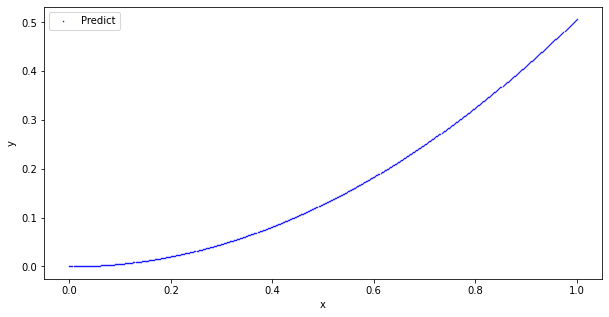

In [21]:
#[TODO]
domain = x.detach().numpy().flatten()
# exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

# plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

# plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

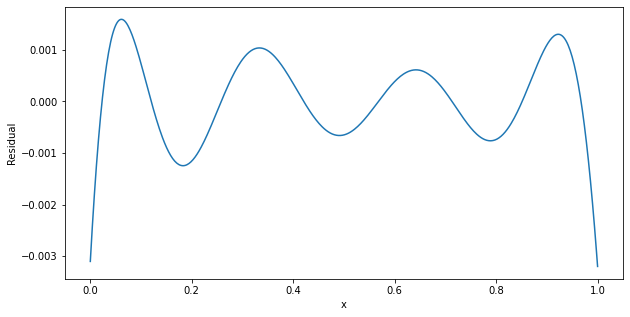

In [22]:
plt.figure(figsize=(10, 5))

res= get_loss(x, ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

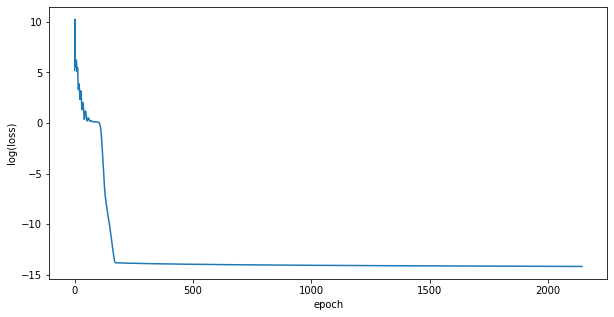

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')